In [1]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.from_numpy(Rx[t:t+Ntest]), torch.from_numpy(Tx[t:t+Ntest]))['Qsq']))
    return Q

# with h5py.File('dataset_A800/train.h5', 'r') as f:
#     for key in f.keys():
#         print('Nch, Rs, Pch, symbs, NF, SF, L:', f[key].attrs['Nch'], f[key].attrs['Rs(GHz)'], f[key].attrs['Pch(dBm)'], f[key]['SymbTx'].shape[1], f[key].attrs['NF(dB)'], f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'], f[key].attrs['distance(km)'])

# 1. DDLMS

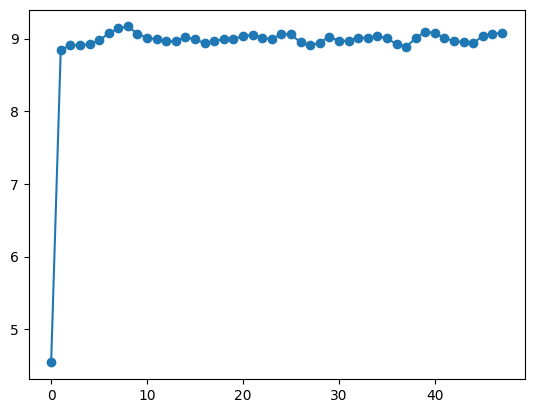

In [42]:
with h5py.File('dataset_A800/test.h5', 'r') as f:
    grp = get_grp(f, 21, 80, 2, 500000, 4.5, 1.2, 2000)
    Q1 = Q_path(grp['Rx_DBP64DDLMS(taps=32,lr=[0.015625, 0.0078125])'][0], grp['Tx'][0,7:-8], Ntest=20000)
plt.plot(Q1, '-o')
# plt.ylim(8, 10)

In [43]:
test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                      window_size=100000, strides=1, Nwindow=1, truncate=20000,
                      Tx_window=True, pre_transform='Rx_DBP64DDLMS(taps=32,lr=[0.015625, 0.0078125])')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

for Rx, Tx,info in test_loader:
    Rx = Rx.to(torch.complex64).to('cpu')
    Tx = Tx.to('cpu')
    break

BER(Rx, Tx)

{'BER': array([[0.00236, 0.00242]], dtype=float32),
 'SER': array([[0.00943, 0.00964]], dtype=float32),
 'Qsq': array([[9.022051, 8.99726 ]], dtype=float32),
 'SNR': array([[15.83424 , 15.844392]], dtype=float32)}

# 2. static filter

In [4]:
train_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                       window_size=1000, strides=1, Nwindow=100, truncate=0,
                       Tx_window=True, pre_transform='Rx_DBP64')
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                      window_size=100000, strides=1, Nwindow=1, truncate=100000,
                      Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
print(len(train_loader))


def test_model(net, test_loader, device):
    for Rx, Tx,info in test_loader:
        Rx = Rx.transpose(1,2).to(torch.complex64).to(device)
        Tx = Tx.to(device)
        break
    with torch.no_grad():
        y = net(Rx).transpose(1,2)
        y0 = Tx

    return Qsq(np.mean(BER(y, y0)['BER']))

10


In [5]:
from src.TorchDSP.layers import ComplexConv1d, ComplexLinear

net = ComplexConv1d(2, 2, 2, stride=2)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
Q_list = []

for epoch in range(40):
    train_loss = 0
    for Rx, Tx,info in train_loader:
        Rx = Rx.transpose(1,2).to(torch.complex64).to(device)
        Tx = Tx.to(device)
        

        y = net(Rx).transpose(1,2)
        y0 = Tx[:,:,:]
        loss = torch.mean(torch.abs(y - y0)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()

    Q_test = test_model(net, test_loader, device)
    Q_list.append(Q_test)

    if epoch % 5 == 0:
        print('Epoch:', epoch, 'Loss:', train_loss/len(train_loader))
        print('Q:', Q_test)

Epoch: 0 Loss: 1.1173790216445922
Q: -1.9721278615519675
Epoch: 5 Loss: 0.030917115695774555
Q: 7.709024132014823
Epoch: 10 Loss: 0.027517986856400965
Q: 7.9953090751991995
Epoch: 15 Loss: 0.02749913837760687
Q: 7.979426836397918
Epoch: 20 Loss: 0.027503243088722228
Q: 7.977170438929719
Epoch: 25 Loss: 0.02750343978404999
Q: 7.981937642226587
Epoch: 30 Loss: 0.027508077397942542
Q: 7.985962888265865
Epoch: 35 Loss: 0.027501942962408064
Q: 7.975417536852567


In [6]:
Q2 = []


for  t in np.arange(0, 480000, 10000):

    test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=20000, strides=1, Nwindow=1, truncate=t,
                        Tx_window=True, pre_transform='Rx_DBP64')
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

    Q2.append(test_model(net, test_loader, device))

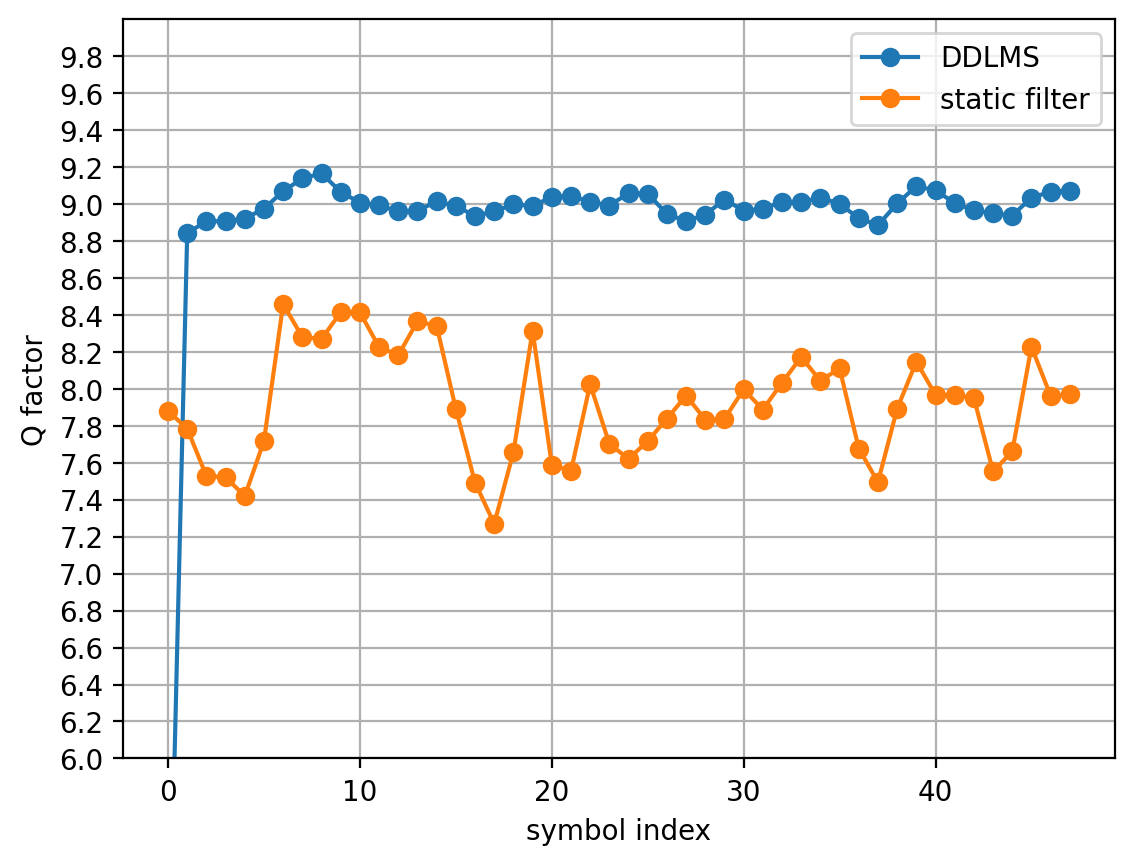

In [44]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 3. BPS

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


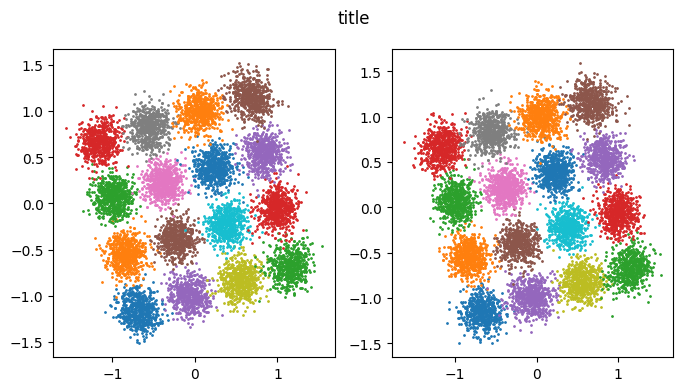

In [45]:
from src.JaxSimulation.dsp import BPS, bps, ddpll

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

ax = show_symb(Rx[0,0::2][0:10000], Tx[0][0:10000], s=1)

array([<Axes: >, <Axes: >], dtype=object)

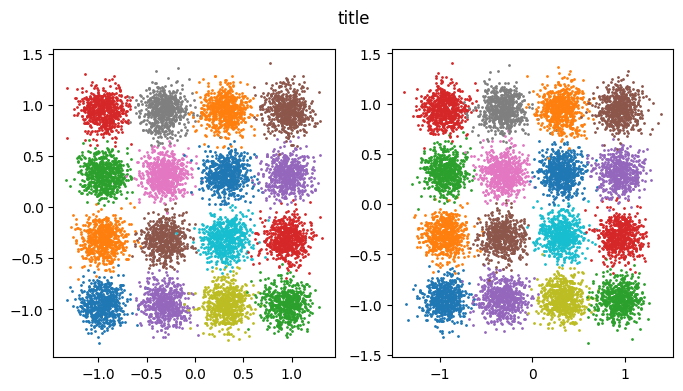

In [46]:
import jax
z, phase, _ = bps(Rx[0,::2].numpy(), 40, const, 161)
Tx_bps = jax.device_get(z)
show_symb(Tx_bps[0:10000], Tx[0].numpy()[0:10000], s=1)

Text(0.5, 1.0, 'Phase Noise')

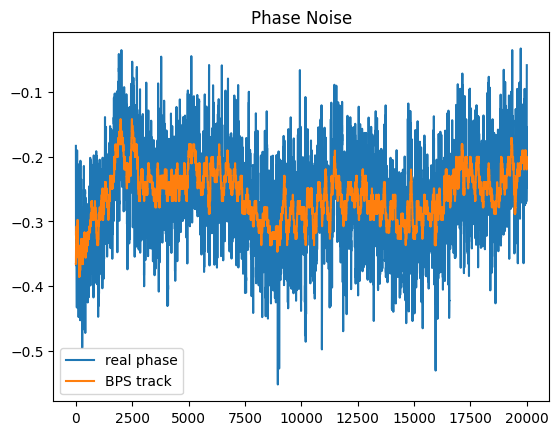

In [47]:
real_phase = - np.angle(Rx[0,::2].numpy() / Tx[0].numpy())
taps = 10
real_phase = np.convolve(real_phase[:,0], np.ones(taps)/taps, mode='same') 

plt.plot(real_phase[0:20000], label='real phase')
plt.plot(phase[0:20000,0], label='BPS track')
plt.legend()
plt.title('Phase Noise')

# 3.5 Real noise compare

In [48]:
def get_noise(Nch, Rs, Pch, taps=100):
    test_data = MyDataset('dataset_A800/test.h5', Nch=[Nch], Rs=[Rs], Pch=[Pch],Nmodes=2,
                            window_size=500000, strides=1, Nwindow=1, truncate=0,
                            Tx_window=True, pre_transform='Rx_DBP64')
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
    for Rx, Tx, info in test_loader:
        # print(Rx.shape, Tx.shape, info.shape)
        break
    real_phase = - np.angle(Rx[0,::2].numpy() / Tx[0].numpy())
    real_phase = real_phase - np.mean(real_phase)
    return np.unwrap(np.convolve(real_phase[:,0], np.ones(taps)/taps, mode='valid'))

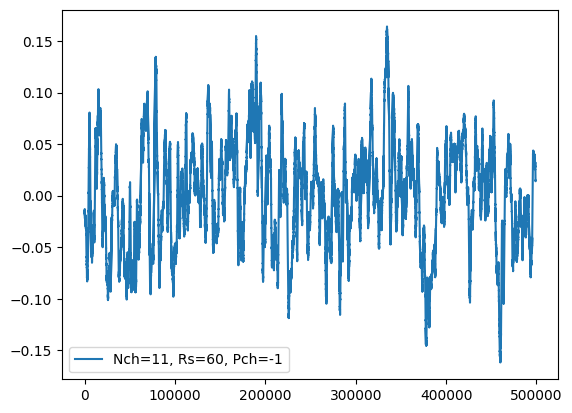

In [49]:
plt.plot(get_noise(11, 80, 3, taps=1000), label='Nch=11, Rs=60, Pch=-1')
# plt.plot(get_noise(21, 80, 3, taps=10000), label='Nch=21, Rs=60, Pch=-1')
plt.legend()

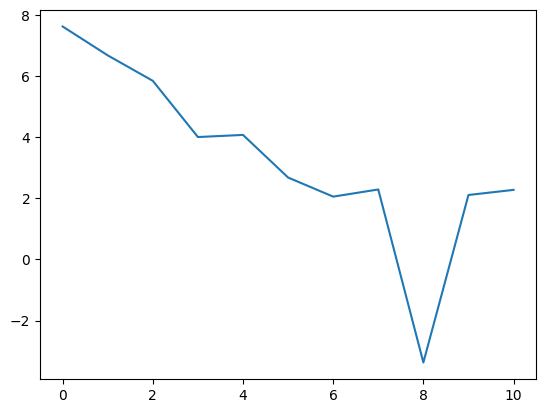

In [50]:
plt.plot([np.log(np.var(get_noise(21, 160, p, taps=1))) for p in range(-3, 8)])

In [51]:
import jax
Q3 = Q_path(Tx_bps, Tx[0].numpy(), Ntest=20000)

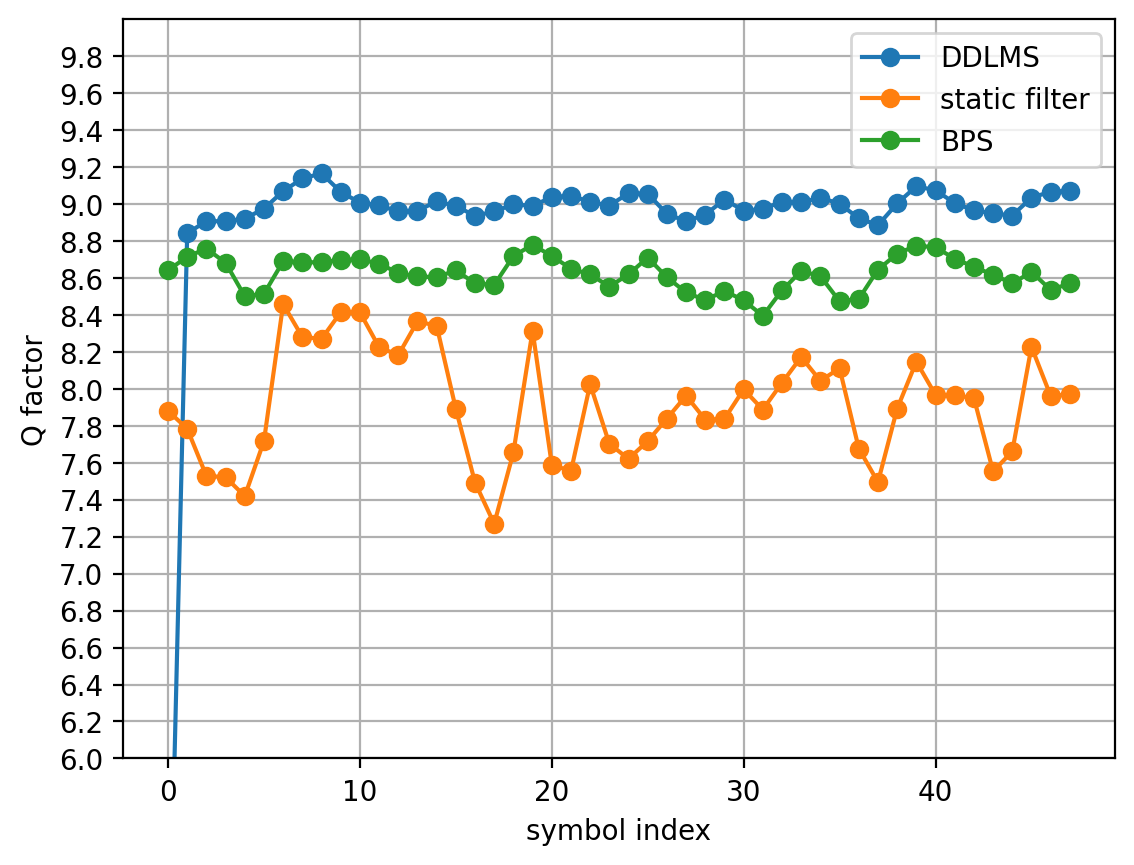

In [52]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 4. DDPLL

In [53]:
from src.JaxSimulation.dsp import BPS, bps, ddpll

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


The best Kv =  0.006
(500000, 2) (500000, 2)


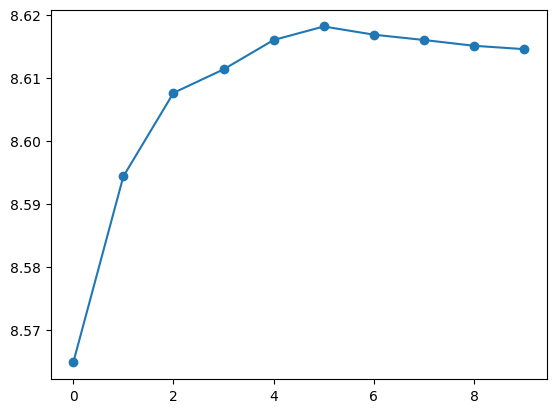

In [54]:
import jax
Qs = []

xis = np.linspace(0.001, 0.01, 10)
for Kv in xis:
    z, phase, _ = ddpll(Rx[0,::2].numpy(), Kv, const, Tx[0].numpy())
    Tx_ddpll = jax.device_get(z)
    Qs.append(Qsq(BER(torch.from_numpy(Tx_ddpll), Tx[0])['BER'].mean()))

plt.plot(Qs, '-o')
Kv = xis[np.argmax(Qs)]

print('The best Kv = ', Kv)
z, phase, _ = ddpll(Rx[0,::2].numpy(), Kv, const, Tx[0].numpy())
Tx_ddpll = jax.device_get(z)
print(z.shape, phase.shape)

In [55]:
Q4 = Q_path(Tx_ddpll, Tx[0].numpy(), Ntest=20000)

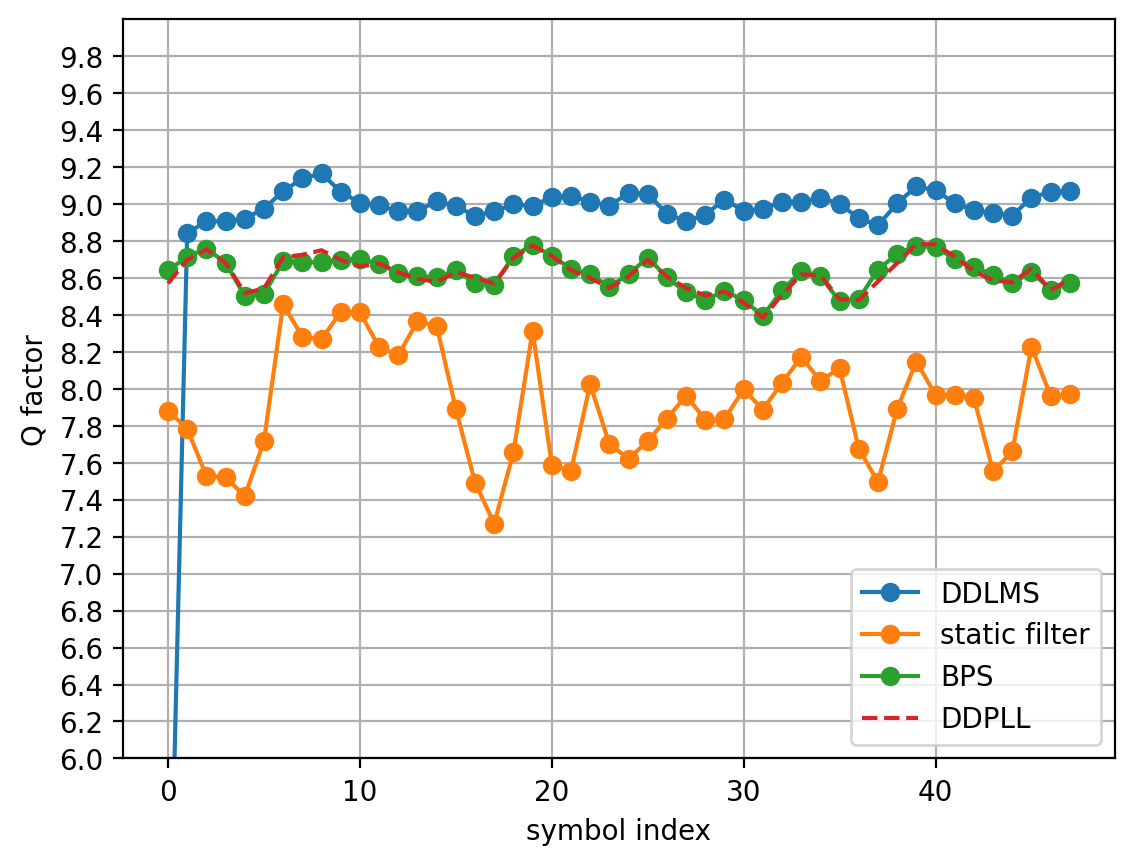

In [56]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.plot(Q4, '--', label='DDPLL')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 5. CPR

In [57]:
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


In [58]:
import jax.numpy as jnp
z, phase, _ = cpr(jnp.array(Rx[0,::2].numpy()), 60, jnp.array(const), jnp.array(Tx[0].numpy()))
Tx_cpr = jax.device_get(z)
print(z.shape, phase.shape)

(500000, 2) (500000, 2)


array([<Axes: >, <Axes: >], dtype=object)

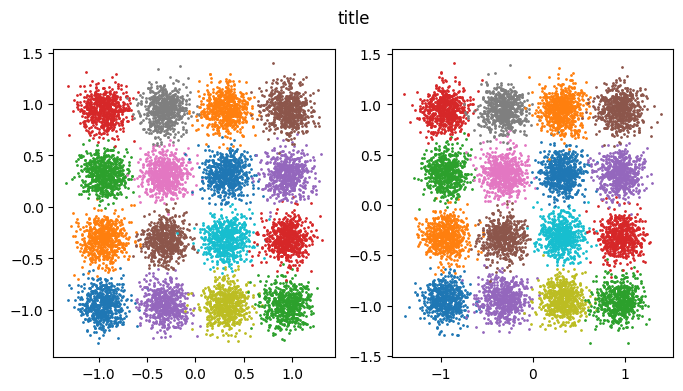

In [59]:
show_symb(Tx_cpr[0:10000], Tx[0].numpy()[0:10000], s=1)

In [60]:
Q5 = Q_path(Tx_cpr, Tx[0].numpy(), Ntest=20000)

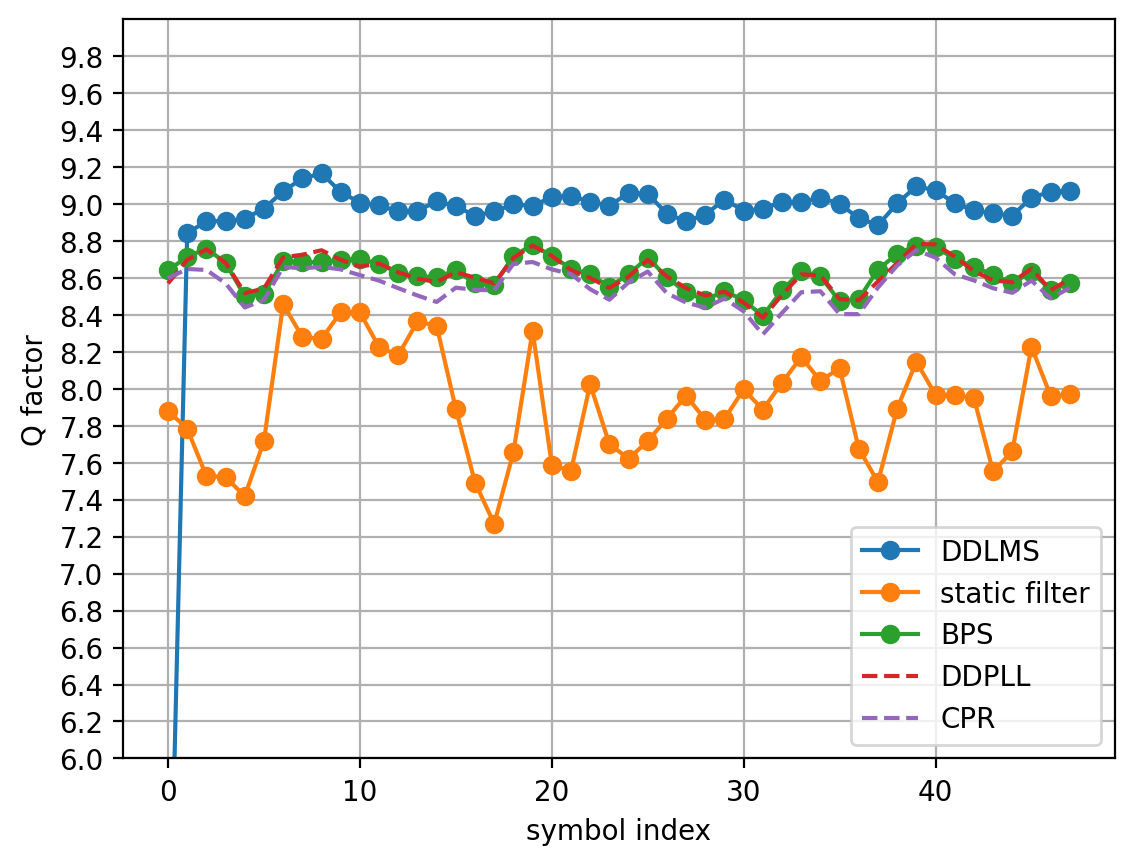

In [67]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.plot(Q4, '--', label='DDPLL')
plt.plot(Q5, '--', label='CPR')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 6. MIMOAF: af.ddlms, af.lms

In [70]:
import numpy as np, jax
from functools import partial
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


In [ ]:
@partial(jax.jit, backend='cpu', static_argnums=(2,3,4,5))   
def DDLMS_jax(Rx, Tx, taps=32, sps=2, lead_symbols=2000, lr=[1/2**6, 1/2**7]):
    signal = MySignal(val=Rx, t=SigTime(0,0,sps), Fs=0)
    truth = MySignal(val=Tx, t=SigTime(0,0,1), Fs=0)
    model = mimoaf(taps=taps, train=lambda n: n<lead_symbols, mimofn=af.ddlms, learnable=False, mimokwargs={'lr_w': lr[0], 'lr_f':lr[1], 'lr_b':0})
    z, state = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
    return z

In [72]:
Q_ddlms = {}

for taps in [64, 32, 16, 8, 4]:
    model = mimoaf(taps=taps, train=lambda n: n<2000, mimofn=af.ddlms, learnable=False)
    z, state = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_ddlms[f'DDLMS taps={taps}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000)

In [73]:
Q_lms = {}

for taps in [64, 32, 16, 8, 4]:
    model = mimoaf(taps=taps, train=lambda n: n<10000, mimofn=af.lms, learnable=False)
    z, state = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_lms[f'LMS taps={taps}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000)

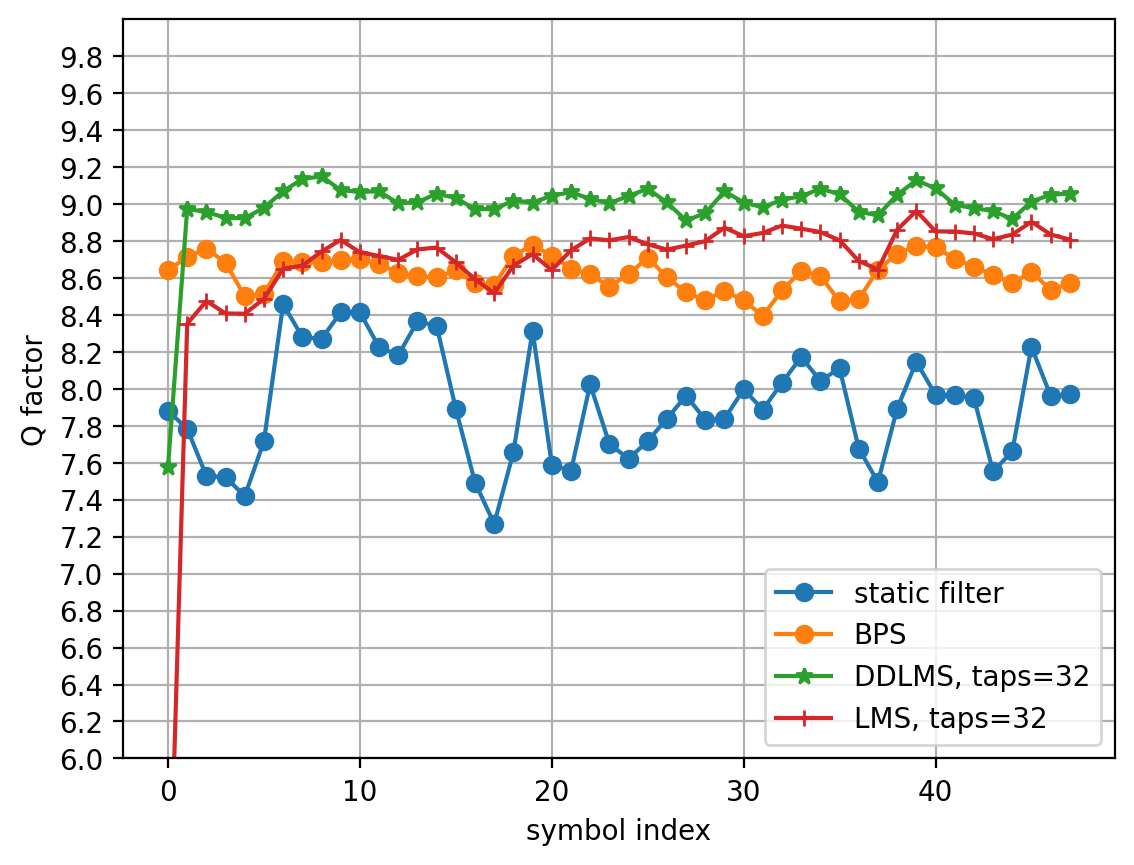

In [74]:
plt.figure(dpi=200)
# plt.plot(Q2, '-o', label='static filter')
# plt.plot(Q3, '--', label='BPS')
# plt.plot(Q4, '--', label='DDPLL')
# plt.plot(Q5, '--', label='CPR')
# for key in Q_ddlms.keys():
#     plt.plot(Q_ddlms[key], '-*', label=key)
# for key in Q_lms.keys():
#     plt.plot(Q_lms[key], '-*', label=key)


plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.plot(Q_ddlms['DDLMS taps=32'], '-*', label='DDLMS, taps=32')
plt.plot(Q_lms['LMS taps=32'], '-+', label='LMS, taps=32')

plt.legend()
plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 7.LMS and DDLMS, change lr

In [93]:
import numpy as np
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader


test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2], Nmodes=2,
                        window_size=200000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

Q_ddlms = {}
Q_lms = {}

for lr in [-3, -4, -5, -6, -7, -8, -9]:
    model = mimoaf(taps=32, train=lambda n: n<2000, mimofn=af.ddlms, learnable=False, mimokwargs={'lr_w': 2**(lr), 'lr_f':2**lr, 'lr_b':0})
    adf = jax.jit(model.init_with_output, backend='cpu', static_argnums=(3))
    z, state = adf(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_ddlms[f'LMS lr=2^{lr}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=5000)

for lr in [-8, -9, -10, -11, -12, -13]:
    model = mimoaf(taps=32, train=lambda n: n<2000, mimofn=af.lms, learnable=False, mimokwargs={'lr': 2**(lr)})
    adf = jax.jit(model.init_with_output, backend='cpu', static_argnums=(3))
    z, state = adf(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_lms[f'LMS lr=2^{lr}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=5000)

torch.Size([1, 400000, 2]) torch.Size([1, 200000, 2]) torch.Size([1, 4])


LMS lr=2^-3 -0.48118654
LMS lr=2^-4 8.716062
LMS lr=2^-5 8.890496
LMS lr=2^-6 8.952122
LMS lr=2^-7 8.930897
LMS lr=2^-8 8.838908
LMS lr=2^-9 8.609535


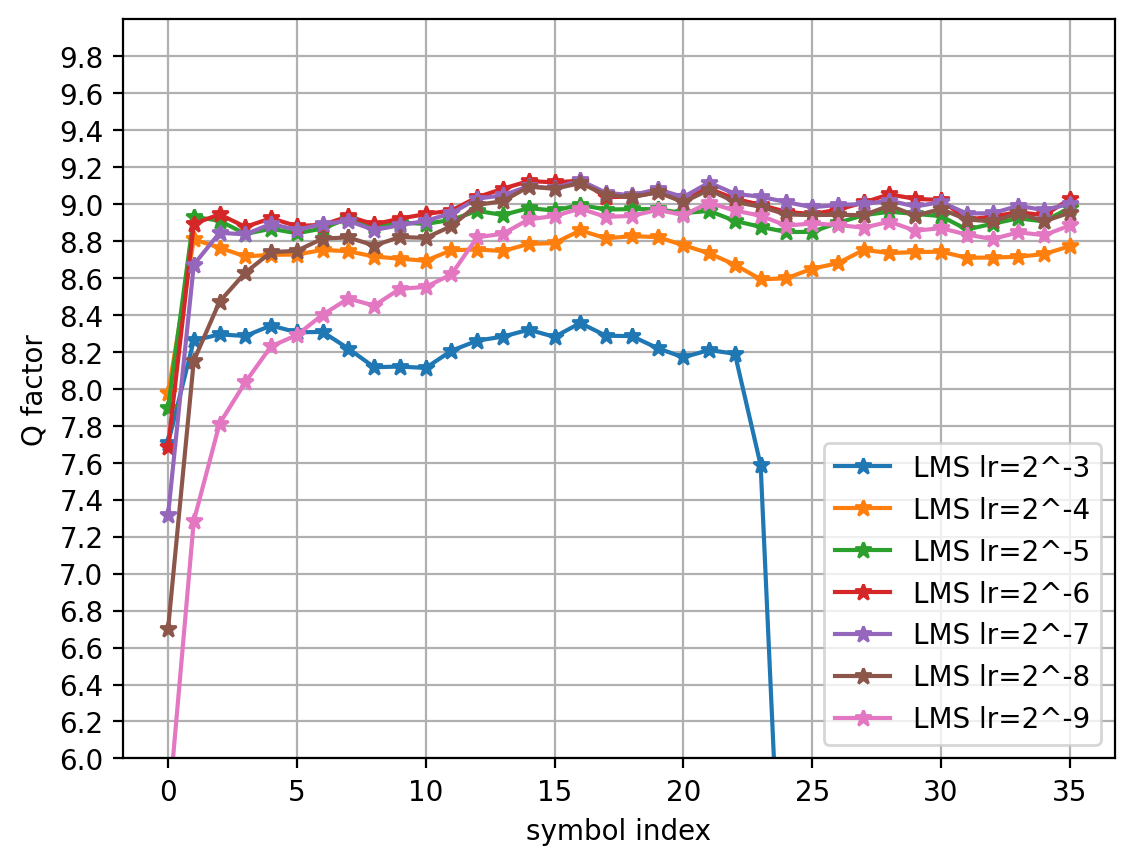

In [95]:
plt.figure(dpi=200)
for key in Q_ddlms.keys():
    plt.plot(Q_ddlms[key], '-*', label=key)
    print(key, np.mean(Q_ddlms[key]))

plt.legend()
plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

LMS lr=2^-8 7.8338876
LMS lr=2^-9 8.553882
LMS lr=2^-10 8.781144
LMS lr=2^-11 8.818414
LMS lr=2^-12 8.739731
LMS lr=2^-13 8.368153


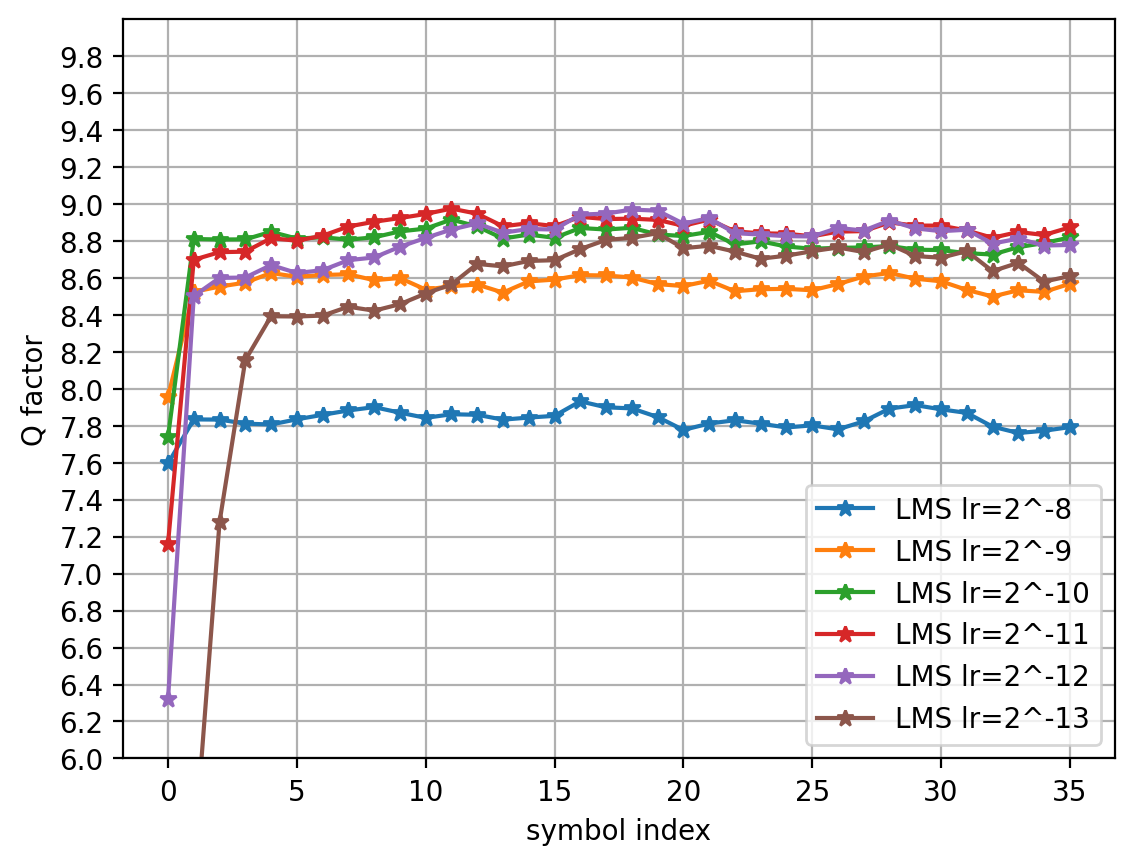

In [89]:
plt.figure(dpi=200)
for key in Q_lms.keys():
    plt.plot(Q_lms[key], '-*', label=key)
    print(key, np.mean(Q_lms[key]))

plt.legend()
plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 7. Meta ADF

In [9]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))
    return Q

from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf, MetaMIMO
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.JaxSimulation.MetaOptimizer import *


test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0], Nmodes=2,
                        window_size=200000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

model = MetaMIMO(taps=32, train=lambda n: n<10000, MetaOpt=MetaNone(lr_init=(1/2**6, 0)))
z, params = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
Q_lms = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=10000, stride=10000)

model = MetaMIMO(taps=32, train=lambda n: n<10000, MetaOpt=MetaNone(lr_init=(1/2**6, 1/2**7)))
z, params = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
Q1 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=10000, stride=10000)


torch.Size([1, 400000, 2]) torch.Size([1, 200000, 2]) torch.Size([1, 4])


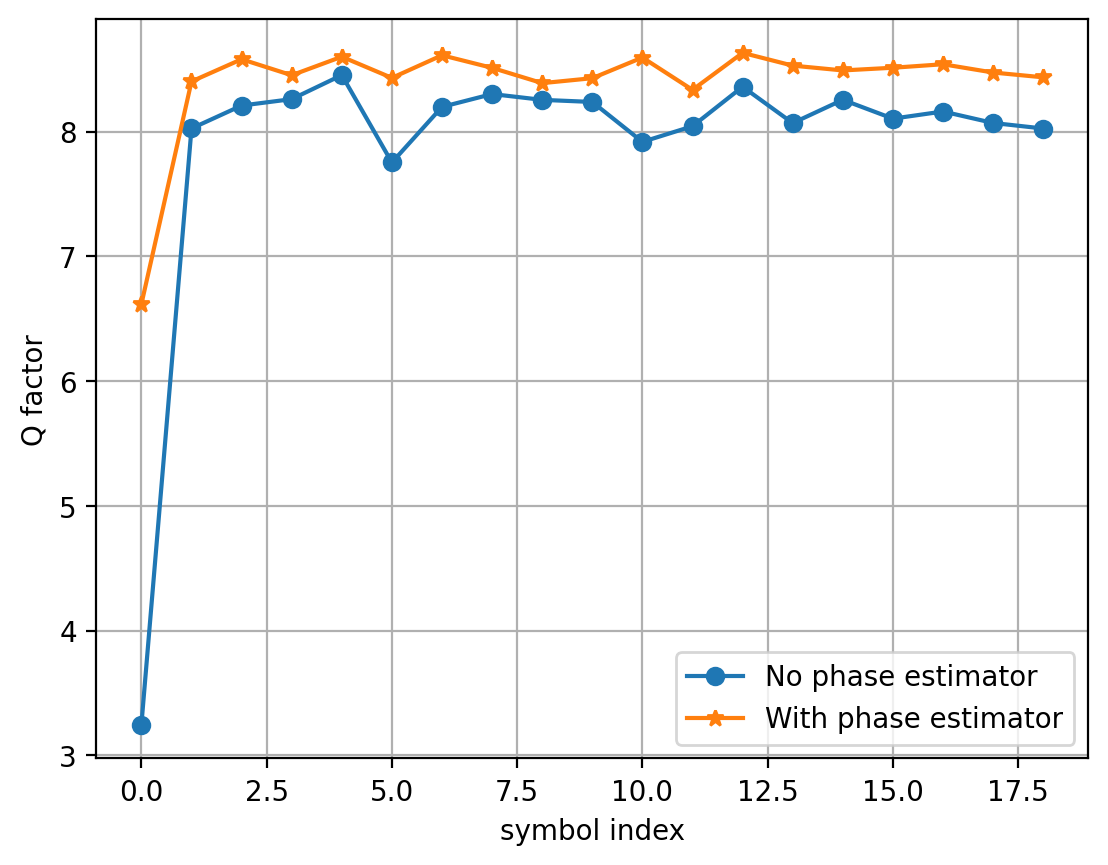

In [10]:
plt.figure(dpi=200)
plt.plot(Q_lms, '-o', label='No phase estimator')
plt.plot(Q1, '-*', label='With phase estimator')

plt.legend()
# plt.ylim(8, 10)
# plt.yticks(np.arange(8, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

## 7.1 MetaAdam

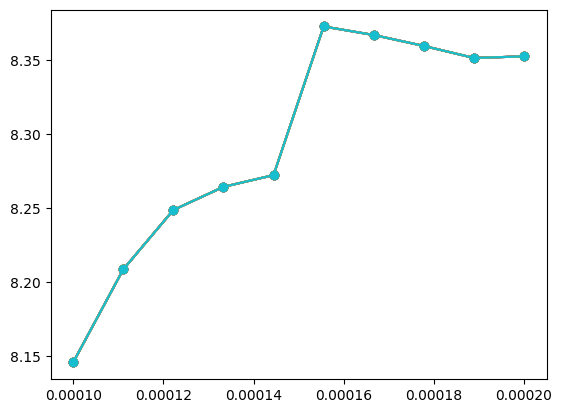

In [8]:
# model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaLSTMOpt_A(hidden_dim=2, depth=1))

Qs = []
for lr in np.linspace(1e-4, 2e-4, 10):
    model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaAdamOpt(learning_rate_init=lr))
    z, params = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
    Qs.append(Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=5000))

# ax = show_symb(jax.device_get(z.val)[10000:20000], Tx[0,z.t.start:z.t.stop].numpy()[10000:20000], s=1)

for key in Qs:
    plt.plot(np.linspace(1e-4, 2e-4, 10), [np.mean(q[2:]) for q in Qs], '-o')

k = np.argmax([np.mean(q[2:]) for q in Qs])
lr  = np.linspace(1e-4, 2e-4, 10)[k]
Q2 = Qs[k]

In [13]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaAdamOpt(learning_rate_init=1.5e-4, b1_init=0.5, b2_init=0.6))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q3 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

In [15]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaAdaGradOpt(learning_rate_init=5e-2, initial_accumulator_value_init=0.1))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q4 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

In [17]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaRmspropOpt(learning_rate_init=1.5e-5, momentum_init=0.9, nesterov=False))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q5 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

In [13]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaSGDOpt(learning_rate_init=1e-2, momentum_init=0.1))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q6 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

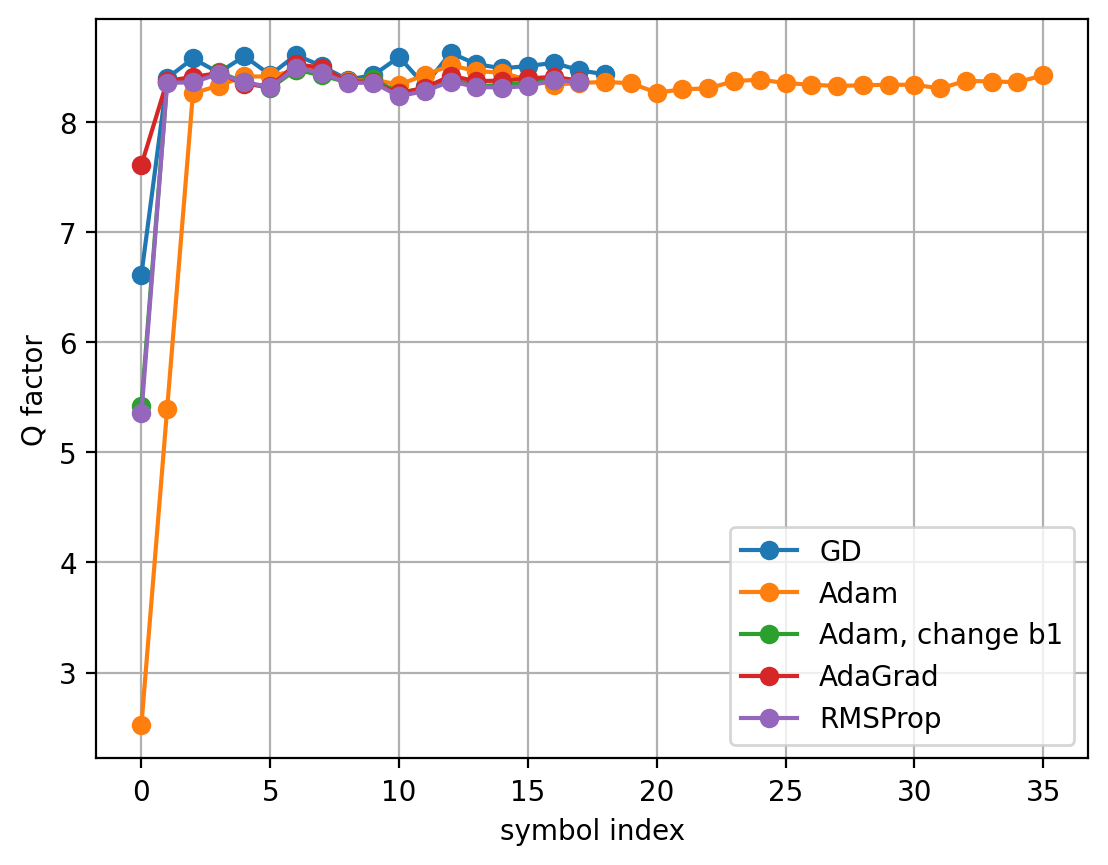

In [18]:
plt.figure(dpi=200)

plt.plot(Q1, '-o', label='GD')
plt.plot(Q2, '-o', label='Adam')
plt.plot(Q3, '-o', label='Adam, change b1')
plt.plot(Q4, '-o', label='AdaGrad')
plt.plot(Q5, '-o', label='RMSProp')
plt.legend()
# plt.ylim(8, 10)
# plt.yticks(np.arange(8, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# Train Metaopt (Jax)

In [2]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader

import os 
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))
    return Q

from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf, MetaMIMO
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.JaxSimulation.MetaOptimizer import *

train_data = MyDataset('dataset_A800/train.h5', Nch=[21], Rs=[40], Pch=[0, 1, 2], Nmodes=2,
                        window_size=400, strides=400-15, Nwindow=200, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)


test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0], Nmodes=2,
                        window_size=200000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

torch.Size([1, 400000, 2]) torch.Size([1, 200000, 2]) torch.Size([1, 4])


In [3]:
model = MetaMIMO(taps=32, train=True, MetaOpt=MetaGRUOpt(hidden_dim=2))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)

from src.JaxSimulation.dsp import  construct_update
update_step = construct_update(model, optax.adam(1e-4), device='cpu', loss_type='MSE')
opt_state = optax.adam(1e-3).init(params['params'])
state_init = params['state']
state = params['state']
param = params['params']

In [4]:
Ls = []

for epoch in range(10):
    N = len(train_loader)
    ls = []
    for i,(Rx, Tx, info) in enumerate(train_loader):
        sig_input = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
        sig_output = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)
        param, state, opt_state,l = update_step(param, state, opt_state, sig_input, sig_output)
        ls.append(l)
        print(f'Batch {i}/{N} loss:',l)
    Ls = Ls + ls
    print(f'epoch {epoch} train loss: {np.mean(ls)}')

Batch 0/10 loss: 0.031530946
Batch 1/10 loss: 0.03223394
Batch 2/10 loss: 0.02897114
Batch 3/10 loss: 0.029874353
Batch 4/10 loss: 0.03337713
Batch 5/10 loss: 0.030278273
Batch 6/10 loss: 0.028987678
Batch 7/10 loss: 0.030675441
Batch 8/10 loss: 0.028453728
Batch 9/10 loss: 0.031542625
epoch 0 train loss: 0.030592525377869606
Batch 0/10 loss: 0.044499256
Batch 1/10 loss: 0.031469785
Batch 2/10 loss: 0.030510902
Batch 3/10 loss: 0.027709153
Batch 4/10 loss: 0.027913416
Batch 5/10 loss: 0.03276514
Batch 6/10 loss: 0.032882184
Batch 7/10 loss: 0.032560587
Batch 8/10 loss: 0.032756668
Batch 9/10 loss: 0.031664547
epoch 1 train loss: 0.032473161816596985
Batch 0/10 loss: 0.029756967
Batch 1/10 loss: 0.035981096
Batch 2/10 loss: 0.04771581
Batch 3/10 loss: 0.030272506
Batch 4/10 loss: 0.028709697
Batch 5/10 loss: 0.03172866
Batch 6/10 loss: 0.035984717
Batch 7/10 loss: 0.02821319
Batch 8/10 loss: 0.031149248
Batch 9/10 loss: 0.028296309
epoch 2 train loss: 0.03278081864118576
Batch 0/10 loss

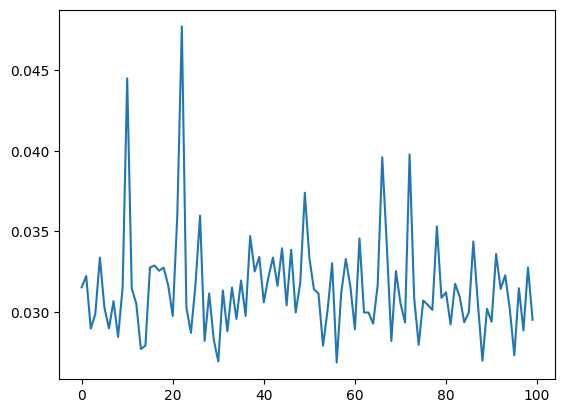

In [5]:
plt.plot(Ls)

In [6]:
model_test = MetaMIMO(taps=32, train=False, MetaOpt=MetaGRUOpt())

from functools import partial
@partial(jax.jit, backend='cpu')
def apply_model(var, signal, truth):
    return model_test.apply(var, signal, truth, True, mutable='state')

In [ ]:
z, _ = apply_model({'params':param, 'state':state_init}, signal, truth)

In [70]:
BER(torch.tensor(jax.device_get(z.val))[20000:], torch.tensor(truth.val[7:-8])[20000:])

{'BER': array([0.00415173, 0.00410451], dtype=float32),
 'SER': array([0.01653471, 0.01631803], dtype=float32),
 'Qsq': array([8.430349, 8.443093], dtype=float32),
 'SNR': array([15.256648, 15.257649], dtype=float32)}

In [71]:
Q = Q_path(jax.device_get(z.val), truth.val[7:-8], Ntest=10000, stride=10000)

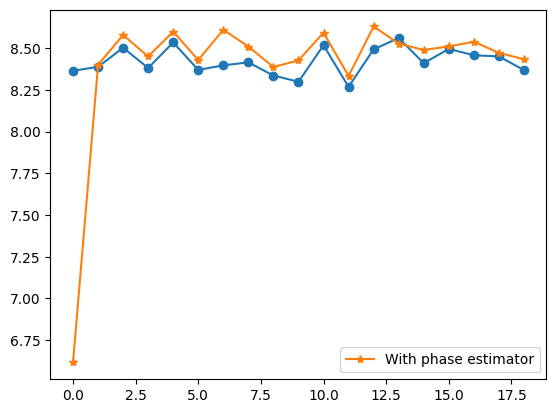

In [72]:
plt.plot(Q, '-o')
plt.plot(Q2, '-*', label='With phase estimator')

plt.legend()

In [28]:
np.mean(Q[3:])

7.469257

# Train MetaOpt (torch)

In [14]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader
from src.TorchDSP.dsp import ADF
from src.TorchDSP.core import TorchSignal, TorchTime

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))
    return Q

from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf, MetaMIMO
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.JaxSimulation.MetaOptimizer import *

train_data = MyDataset('dataset_A800/train.h5', Nch=[21], Rs=[80], Pch=[5],Nmodes=2,
                        window_size=400, strides=400-15, Nwindow=200, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[5],Nmodes=2,
                        window_size=400, strides=400-15, Nwindow=100, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = TorchSignal(val=Rx, t=TorchTime(0,0,2))
truth = TorchSignal(val=Tx, t=TorchTime(0,0,1))

torch.Size([1, 800, 2]) torch.Size([1, 400, 2]) torch.Size([1, 4])


In [15]:
device = 'cpu'
model = ADF(method='metagrutest', taps=32, Nmodes=2, batch_size=20, lead_symbols=2000, mode='train', meta_args={'step_max':5e-2, 'hidden_dim':8, 'num_layers':2})
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
for epoch in range(10):
    Ls = []
    for Rx1, Tx1, info1 in train_loader:
        rx = TorchSignal(val=Rx1, t=TorchTime(0,0,2)).to(device)
        tx = TorchSignal(val=Tx1, t=TorchTime(0,0,1)).to(device)
        info1 = info1.to(device)
        sig = model(rx, tx, info1)
        loss = torch.mean(torch.abs(sig.val - tx.val[:,sig.t.start:sig.t.stop])**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.detach_state()

        print(loss.item())

        Ls.append(loss.item())
    print(f'epoch {epoch}:',np.mean(Ls))

0.7667393684387207
0.4174982011318207
0.21287010610103607
0.1232786551117897
0.08175048232078552
0.06454456597566605
0.05391385033726692
0.04959145188331604
0.04935448616743088
0.04496300593018532
epoch 0: 0.18645041733980178
0.043745074421167374
0.04462556168437004
0.043872684240341187
0.04486410319805145
0.042156316339969635
0.04377244412899017
0.041087567806243896
0.04263899475336075
0.0426505021750927
0.04374941065907478
epoch 1: 0.0433162659406662
0.04168575257062912
0.04266059026122093
0.04257999733090401
0.04374774917960167
0.04230904579162598
0.04083194211125374
0.044776301831007004
0.04336448386311531
0.042698077857494354
0.04300596937537193
epoch 2: 0.04276599101722241
0.0415966622531414
0.04362160712480545
0.043161798268556595
0.04307137057185173
0.043078500777482986
0.04431507736444473
0.042346157133579254
0.041565995663404465
0.040105197578668594
0.04102732986211777
epoch 3: 0.0423889696598053
0.042465709149837494
0.04198053479194641
0.04143374785780907
0.04112411662936210

In [78]:
test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0],Nmodes=2,
                        window_size=500000, strides=400-15, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [79]:
model.change_mode('test')
model.change_batchsize(1)
model.to('cpu')
ber = 0
for Rx1, Tx1, info1 in test_loader:
    rx = TorchSignal(val=Rx1, t=TorchTime(0,0,2)).to('cpu')
    tx = TorchSignal(val=Tx1, t=TorchTime(0,0,1)).to('cpu')
    info1 = info1.to('cpu')
    with torch.no_grad():
        sig = model(rx, tx, info1)

In [80]:
Q_meta = Q_path(sig.val.cpu().data[0], tx.val[0,7:-8].cpu().data)

/tmp/ipykernel_2107354/2093106935.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))


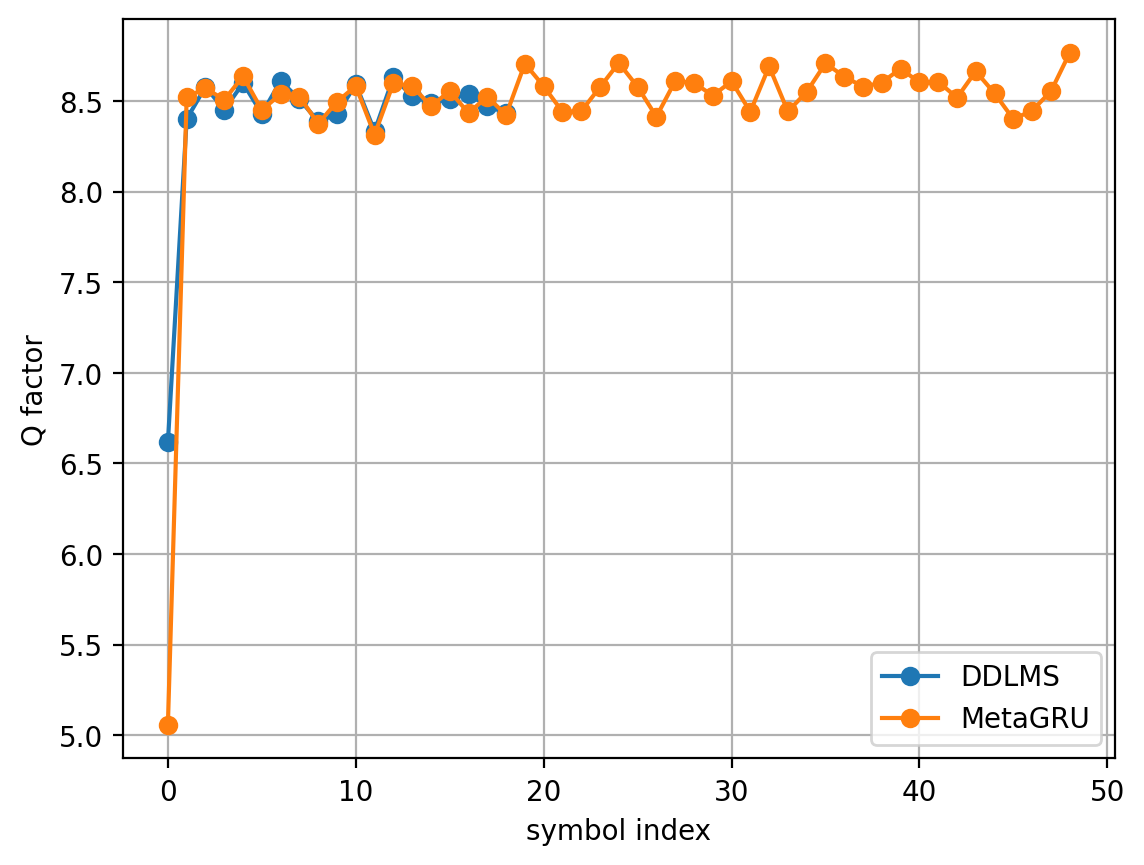

In [81]:
plt.figure(dpi=200)
plt.plot(Q2, '-o', label='DDLMS')
plt.plot(Q_meta, '-o', label='MetaGRU')
plt.legend()
# plt.ylim(8, 10)
# plt.yticks(np.arange(8, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

In [12]:
np.mean(Q_meta[5:10])

8.534943

In [13]:
np.mean(Q2[5:10])

8.530167

# small 

In [13]:
model.change_mode('test')
sig = model(signal, truth, info)
BER(sig.val[:,:], truth.val[:,7:-8][:,:])

{'BER': array([[0.01947605, 0.02845442]], dtype=float32),
 'SER': array([[0.07080155, 0.10271352]], dtype=float32),
 'Qsq': array([[6.2971077, 5.593386 ]], dtype=float32),
 'SNR': array([[13.506484, 12.637691]], dtype=float32)}

In [17]:
BER(sig.val[:,20000:], truth.val[:,7:-8][:,20000:])

{'BER': array([[0.00227671, 0.0028021 ]], dtype=float32),
 'SER': array([[0.00905679, 0.01120841]], dtype=float32),
 'Qsq': array([[9.057304, 8.849856]], dtype=float32),
 'SNR': array([[15.843673 , 15.7266865]], dtype=float32)}

## after traing

In [5]:
model.change_mode('test')
sig = model(signal, truth, info)
BER(sig.val[:,:], truth.val[:,7:-8][:,:])

{'BER': array([[0.0025322 , 0.00277604]], dtype=float32),
 'SER': array([[0.01007878, 0.01105415]], dtype=float32),
 'Qsq': array([[8.95218 , 8.859388]], dtype=float32),
 'SNR': array([[15.751697, 15.736883]], dtype=float32)}

In [8]:
BER(sig.val[:,10000:], truth.val[:,7:-8][:,10000:])

{'BER': array([[0.00231783, 0.00269301]], dtype=float32),
 'SER': array([[0.0092046, 0.0107387]], dtype=float32),
 'Qsq': array([[9.039775, 8.890237]], dtype=float32),
 'SNR': array([[15.800156, 15.78038 ]], dtype=float32)}